In [2]:
# --- Path setup: allow importing from scripts/ ---
import sys
from pathlib import Path

# project root = previous directory

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(sys.path)

print("Project root:", PROJECT_ROOT)

# --- Import model + helpers ---
from scripts.models import ConditionalVAE, vae_loss, linear_beta_schedule


['/home/satan/git/VAE-Timbre-Spaces', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python310.zip', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/lib-dynload', '', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages']
Project root: /home/satan/git/VAE-Timbre-Spaces


In [28]:
# --- Reprodutibilidade ---
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
if device.type == "cuda":
    print("gpu:", torch.cuda.get_device_name(0))
    print("torch cuda:", torch.version.cuda)

# --- Audio parameters ---
SR = 16000
N_MELS = 80
N_FFT = 2048
HOP = 256
T = 128  # fixed number of time frames

# --- Training parameters ---
BATCH_SIZE = 128
EPOCHS = 15
LR = 1e-3

# --- Conditional VAE / anti-collapse ---
LATENT_DIM = 32
BETA_MAX = 2.0
WARMUP_STEPS = 500
FREE_BITS = 0.5

print("Config OK")


device: cuda
gpu: NVIDIA GeForce RTX 3060 Ti
torch cuda: 12.1
Config OK


In [29]:
from pathlib import Path

# --- Paths (ajuste se necessário) ---
DATA_ROOT = Path("../data/nsynth-valid.jsonwav/nsynth-valid")  # mesma estrutura que você mostrou
AUDIO_DIR = DATA_ROOT / "audio"
JSON_PATH = DATA_ROOT / "examples.json"

print("DATA_ROOT :", DATA_ROOT)
print("AUDIO_DIR exists:", AUDIO_DIR.exists(), "|", AUDIO_DIR)
print("JSON_PATH exists:", JSON_PATH.exists(), "|", JSON_PATH)


DATA_ROOT : ../data/nsynth-valid.jsonwav/nsynth-valid
AUDIO_DIR exists: True | ../data/nsynth-valid.jsonwav/nsynth-valid/audio
JSON_PATH exists: True | ../data/nsynth-valid.jsonwav/nsynth-valid/examples.json


In [30]:
import json

with open(JSON_PATH, "r") as f:
    examples = json.load(f)

keys = list(examples.keys())
print("Number of examples:", len(keys))

# sanity check: mostrar alguns exemplos
for k in keys[:3]:
    meta = examples[k]
    print(
        k,
        "| pitch:", meta["pitch"],
        "| family:", meta["instrument_family"],
        "| source:", meta.get("instrument_source", None),
    )


Number of examples: 12678
keyboard_acoustic_004-060-025 | pitch: 60 | family: 4 | source: 0
bass_synthetic_033-050-100 | pitch: 50 | family: 0 | source: 2
bass_synthetic_009-052-050 | pitch: 52 | family: 0 | source: 2


In [31]:
from torch.utils.data import Dataset
import torch


CACHE_DIR = Path("../data/nsynth_mel_cache") # ajuste se o seu cache estiver em outro lugar
print("CACHE_DIR exists:", CACHE_DIR.exists(), "|", CACHE_DIR)

class NsynthMelCacheDataset(Dataset):
    def __init__(self, keys, examples, cache_dir: Path):
        self.keys = keys
        self.examples = examples
        self.cache_dir = cache_dir

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]

        # x: (1, 80, T) já normalizado no cache
        pt_path = self.cache_dir / f"{k}.pt"
        x = torch.load(pt_path, weights_only=True)  # safer + remove warning

        pitch = int(self.examples[k]["pitch"])  # 0..127
        family = int(self.examples[k]["instrument_family"])

        return x, pitch, family, k

# sanity check (1 sample)
ds_tmp = NsynthMelCacheDataset(keys[:10], examples, CACHE_DIR)
x0, p0, f0, k0 = ds_tmp[0]
print("sample key:", k0)
print("x shape:", tuple(x0.shape), "| dtype:", x0.dtype)
print("pitch:", p0, "| family:", f0)


CACHE_DIR exists: True | ../data/nsynth_mel_cache
sample key: keyboard_acoustic_004-060-025
x shape: (1, 80, 128) | dtype: torch.float32
pitch: 60 | family: 4


In [32]:
from torch.utils.data import DataLoader

# --- Split (80/20) ---
rng = np.random.default_rng(SEED)
keys_shuffled = keys.copy()
rng.shuffle(keys_shuffled)

split_idx = int(0.8 * len(keys_shuffled))
train_keys = keys_shuffled[:split_idx]
val_keys   = keys_shuffled[split_idx:]

print("train:", len(train_keys), "val:", len(val_keys))

train_ds = NsynthMelCacheDataset(train_keys, examples, CACHE_DIR)
val_ds   = NsynthMelCacheDataset(val_keys, examples, CACHE_DIR)

# --- DataLoaders ---
pin = (device.type == "cuda")

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,              # você já viu que 8 ajudou
    pin_memory=pin,
    persistent_workers=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=pin,
    persistent_workers=True,
)

# sanity check batch
x, pitch, family, k = next(iter(train_loader))
print("batch x:", tuple(x.shape), x.dtype)
print("batch pitch:", pitch.shape, pitch.dtype, "| min/max:", int(pitch.min()), int(pitch.max()))
print("batch family:", family.shape, family.dtype, "| min/max:", int(family.min()), int(family.max()))
print("first key:", k[0])


train: 10142 val: 2536
batch x: (128, 1, 80, 128) torch.float32
batch pitch: torch.Size([128]) torch.int64 | min/max: 20 108
batch family: torch.Size([128]) torch.int64 | min/max: 0 10
first key: bass_synthetic_009-053-025


In [33]:
import torch

# --- Model ---
cvae = ConditionalVAE(
    latent_dim=LATENT_DIM,
    pitch_vocab=128,
    cond_dim=16,      # embedding do pitch
).to(device)

optimizer = torch.optim.Adam(cvae.parameters(), lr=LR)

def beta_schedule(global_step: int) -> float:
    return linear_beta_schedule(
        global_step=global_step,
        warmup_steps=WARMUP_STEPS,
        beta_max=BETA_MAX,
    )

print("ConditionalVAE initialized")
print("Total parameters:", sum(p.numel() for p in cvae.parameters()))


ConditionalVAE initialized
Total parameters: 1223793


In [34]:
import torch

# --- get one batch ---
x, pitch, family, k = next(iter(train_loader))

x = x.to(device, non_blocking=True)                 # (B,1,80,128)
pitch = pitch.to(device, non_blocking=True)         # (B,)
family = family.to(device, non_blocking=True)       # (B,) (não usamos ainda, mas mantemos)

# --- forward ---
x_hat, mu, logvar, z = cvae(x, pitch)

print("Shapes:")
print("x     :", tuple(x.shape))
print("x_hat :", tuple(x_hat.shape))
print("mu    :", tuple(mu.shape))
print("logvar:", tuple(logvar.shape))
print("z     :", tuple(z.shape))

# --- loss ---
beta = beta_schedule(global_step=0)
total, recon, kl_raw, kl_fb = vae_loss(
    x_hat, x, mu, logvar,
    beta=beta,
    free_bits=FREE_BITS,
)

print("\nLosses (untrained sanity check):")
print("beta :", beta)
print("total:", float(total))
print("recon:", float(recon))
print("kl_raw:", float(kl_raw))
print("kl_fb :", float(kl_fb))


Shapes:
x     : (128, 1, 80, 128)
x_hat : (128, 1, 80, 128)
mu    : (128, 32)
logvar: (128, 32)
z     : (128, 32)

Losses (untrained sanity check):
beta : 0.0
total: 0.830173671245575
recon: 0.830173671245575
kl_raw: 0.03167380392551422
kl_fb : 0.5


In [35]:
import time
import numpy as np
import torch

def train_one_epoch(model, loader, optimizer, global_step: int, log_every: int = 200):
    model.train()
    stats = {"total": [], "recon": [], "kl_raw": [], "kl_fb": []}

    for x, pitch, family, k in loader:
        x = x.to(device, non_blocking=True)
        pitch = pitch.to(device, non_blocking=True)

        beta = beta_schedule(global_step)

        x_hat, mu, logvar, z = model(x, pitch)

        total, recon, kl_raw, kl_fb = vae_loss(
            x_hat, x, mu, logvar,
            beta=beta,
            free_bits=FREE_BITS,
        )

        optimizer.zero_grad(set_to_none=True)
        total.backward()
        optimizer.step()

        stats["total"].append(total.item())
        stats["recon"].append(recon.item())
        stats["kl_raw"].append(kl_raw.item())
        stats["kl_fb"].append(kl_fb.item())

        if global_step % log_every == 0:
            print(
                f"[step {global_step}] beta={beta:.3f} "
                f"total={total.item():.3f} recon={recon.item():.3f} "
                f"kl_raw={kl_raw.item():.3f} kl_fb={kl_fb.item():.3f}"
            )

        global_step += 1

    return stats, global_step


@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    stats = {"total": [], "recon": [], "kl_raw": [], "kl_fb": []}

    for x, pitch, family, k in loader:
        x = x.to(device, non_blocking=True)
        pitch = pitch.to(device, non_blocking=True)

        x_hat, mu, logvar, z = model(x, pitch)

        # em validação, beta=1.0 só pra acompanhar números
        total, recon, kl_raw, kl_fb = vae_loss(
            x_hat, x, mu, logvar,
            beta=1.0,
            free_bits=FREE_BITS,
        )

        stats["total"].append(total.item())
        stats["recon"].append(recon.item())
        stats["kl_raw"].append(kl_raw.item())
        stats["kl_fb"].append(kl_fb.item())

    return stats


def summarize_stats(stats: dict) -> dict:
    return {k: float(np.mean(v)) for k, v in stats.items()}


In [36]:
global_step = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_stats, global_step = train_one_epoch(
        cvae, train_loader, optimizer, global_step, log_every=200
    )
    val_stats = eval_one_epoch(cvae, val_loader)

    train_mean = summarize_stats(train_stats)
    val_mean = summarize_stats(val_stats)

    print(f"\nEpoch {epoch}/{EPOCHS} ({time.time() - t0:.1f}s)")
    print(
        f"  Train: total={train_mean['total']:.3f} "
        f"recon={train_mean['recon']:.3f} "
        f"kl_raw={train_mean['kl_raw']:.3f} "
        f"kl_fb={train_mean['kl_fb']:.3f}"
    )
    print(
        f"  Val  : total={val_mean['total']:.3f} "
        f"recon={val_mean['recon']:.3f} "
        f"kl_raw={val_mean['kl_raw']:.3f} "
        f"kl_fb={val_mean['kl_fb']:.3f}"
    )


[step 0] beta=0.000 total=0.817 recon=0.817 kl_raw=0.031 kl_fb=0.500

Epoch 1/15 (1.0s)
  Train: total=0.441 recon=0.359 kl_raw=0.368 kl_fb=0.546
  Val  : total=0.748 recon=0.240 kl_raw=0.388 kl_fb=0.508

Epoch 2/15 (0.8s)
  Train: total=0.472 recon=0.231 kl_raw=0.356 kl_fb=0.503
  Val  : total=0.732 recon=0.225 kl_raw=0.413 kl_fb=0.506
[step 200] beta=0.800 total=0.585 recon=0.185 kl_raw=0.394 kl_fb=0.500

Epoch 3/15 (0.7s)
  Train: total=0.618 recon=0.218 kl_raw=0.384 kl_fb=0.501
  Val  : total=0.712 recon=0.212 kl_raw=0.380 kl_fb=0.500

Epoch 4/15 (0.7s)
  Train: total=0.769 recon=0.209 kl_raw=0.366 kl_fb=0.501
  Val  : total=0.705 recon=0.205 kl_raw=0.391 kl_fb=0.500

Epoch 5/15 (0.8s)
  Train: total=0.914 recon=0.194 kl_raw=0.426 kl_fb=0.501
  Val  : total=0.696 recon=0.195 kl_raw=0.398 kl_fb=0.500
[step 400] beta=1.600 total=0.995 recon=0.195 kl_raw=0.397 kl_fb=0.500

Epoch 6/15 (0.7s)
  Train: total=1.075 recon=0.195 kl_raw=0.379 kl_fb=0.501
  Val  : total=0.713 recon=0.212 kl_r

In [37]:
import numpy as np
import torch

N_SAMPLES = 2000  # ajuste se quiser mais/menos

cvae.eval()

mus = []
pitches = []
families = []
keys_out = []

with torch.no_grad():
    for x, pitch, family, k in val_loader:
        x = x.to(device, non_blocking=True)

        # mu(x) do encoder (não precisa do pitch aqui)
        mu, logvar = cvae.encoder(x)  # (B, latent_dim)

        mus.append(mu.cpu())
        pitches.append(pitch.cpu())
        families.append(family.cpu())
        keys_out.extend(list(k))

        if sum(m.shape[0] for m in mus) >= N_SAMPLES:
            break

mu_all = torch.cat(mus, dim=0)[:N_SAMPLES].numpy()
pitch_all = torch.cat(pitches, dim=0)[:N_SAMPLES].numpy()
family_all = torch.cat(families, dim=0)[:N_SAMPLES].numpy()
keys_all = np.array(keys_out[:N_SAMPLES])

print("mu_all:", mu_all.shape)
print("pitch_all:", pitch_all.shape, "| min/max:", pitch_all.min(), pitch_all.max())
print("family_all:", family_all.shape, "| unique:", len(np.unique(family_all)))
print("keys_all:", keys_all.shape)


mu_all: (2000, 32)
pitch_all: (2000,) | min/max: 9 117
family_all: (2000,) | unique: 10
keys_all: (2000,)


In [38]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

# --- PCA 2D ---
pca = PCA(n_components=2, random_state=SEED)
mu_pca = pca.fit_transform(mu_all)

print("Explained variance ratio:", pca.explained_variance_ratio_, 
      "| sum:", pca.explained_variance_ratio_.sum())

# DataFrame-like dict (pra plotly)
data = {
    "pc1": mu_pca[:, 0],
    "pc2": mu_pca[:, 1],
    "pitch": pitch_all.astype(int),
    "instrument_family": family_all.astype(int),
    "key": keys_all,
}

# --- Plot 1: color by instrument_family ---
fig1 = px.scatter(
    data,
    x="pc1",
    y="pc2",
    color="instrument_family",
    hover_data=["pitch", "key"],
    title="PCA (mu) — color: instrument_family",
)
fig1.show()

# --- Plot 2: color by pitch ---
fig2 = px.scatter(
    data,
    x="pc1",
    y="pc2",
    color="pitch",
    hover_data=["instrument_family", "key"],
    title="PCA (mu) — color: pitch",
)
fig2.show()


Explained variance ratio: [0.9593664  0.03080329] | sum: 0.9901697


In [39]:
import umap
import plotly.express as px

# --- Map instrument family to readable labels ---
NSYNTH_FAMILY_MAP = {
    0: "bass",
    1: "brass",
    2: "flute",
    3: "guitar",
    4: "keyboard",
    5: "mallet",
    6: "organ",
    7: "reed",
    8: "string",
    9: "synth_lead",
    10: "vocal",
}

family_labels = [
    f"{fid} – {NSYNTH_FAMILY_MAP.get(fid, 'unknown')}"
    for fid in family_all
]

# --- UMAP 2D ---
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=SEED,
)
mu_umap = reducer.fit_transform(mu_all)

data_umap = {
    "u1": mu_umap[:, 0],
    "u2": mu_umap[:, 1],
    "pitch": pitch_all.astype(int),
    "instrument_family": family_all.astype(int),
    "family_label": family_labels,
    "key": keys_all,
}

# --- Plot 1: color by instrument_family (with labels) ---
fig1 = px.scatter(
    data_umap,
    x="u1",
    y="u2",
    color="family_label",
    hover_data=["pitch", "key"],
    title="UMAP (mu) — color: instrument_family",
)
fig1.show()

# --- Plot 2: color by pitch ---
fig2 = px.scatter(
    data_umap,
    x="u1",
    y="u2",
    color="pitch",
    hover_data=["family_label", "key"],
    title="UMAP (mu) — color: pitch",
)
fig2.show()


/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Example key: bass_electronic_027-034-075
pitch: 34 | family: 0
x     min/max: -80.0 0.0
x_hat min/max: -85.61061 -5.8248596


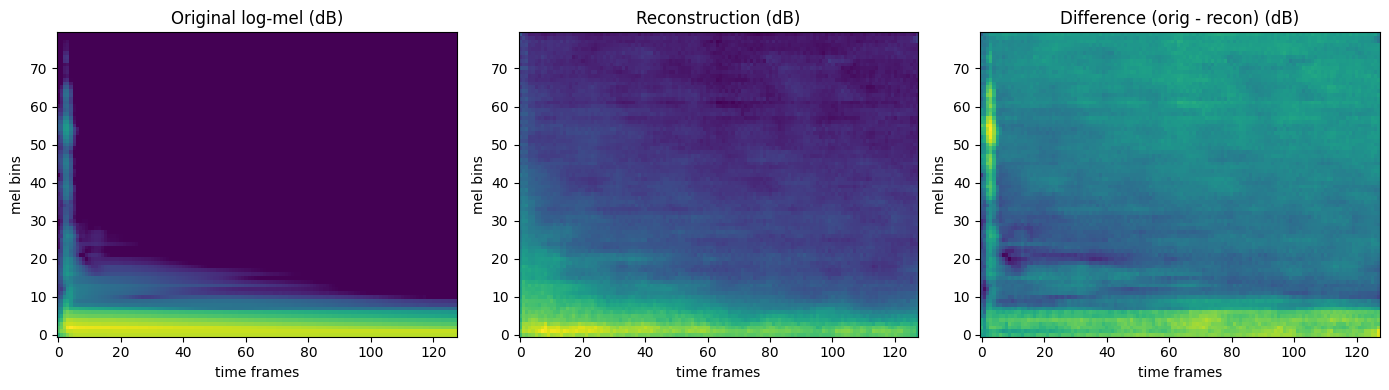

In [40]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def denormalize_db(x_norm: np.ndarray) -> np.ndarray:
    """
    x_norm: values in [-1, 1]
    returns: values in [-80, 0] dB
    """
    x_01 = (x_norm + 1.0) / 2.0          # [0, 1]
    x_db = x_01 * 80.0 - 80.0            # [-80, 0]
    return x_db

# --- pick one batch from val ---
cvae.eval()
x, pitch, family, k = next(iter(val_loader))
x = x.to(device, non_blocking=True)
pitch = pitch.to(device, non_blocking=True)

with torch.no_grad():
    x_hat, mu, logvar, z = cvae(x, pitch)

# choose one example in the batch
i = 0
x_i = x[i, 0].detach().cpu().numpy()        # (80, T)
xhat_i = x_hat[i, 0].detach().cpu().numpy() # (80, T)

x_i_db = denormalize_db(x_i)
xhat_i_db = denormalize_db(xhat_i)
diff_db = x_i_db - xhat_i_db

print("Example key:", k[i])
print("pitch:", int(pitch[i].cpu()), "| family:", int(family[i].cpu()))
print("x     min/max:", x_i_db.min(), x_i_db.max())
print("x_hat min/max:", xhat_i_db.min(), xhat_i_db.max())

# --- plot side-by-side ---
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].imshow(x_i_db, aspect="auto", origin="lower")
axs[0].set_title("Original log-mel (dB)")
axs[0].set_xlabel("time frames")
axs[0].set_ylabel("mel bins")

axs[1].imshow(xhat_i_db, aspect="auto", origin="lower")
axs[1].set_title("Reconstruction (dB)")
axs[1].set_xlabel("time frames")
axs[1].set_ylabel("mel bins")

axs[2].imshow(diff_db, aspect="auto", origin="lower")
axs[2].set_title("Difference (orig - recon) (dB)")
axs[2].set_xlabel("time frames")
axs[2].set_ylabel("mel bins")

plt.tight_layout()
plt.show()


In [41]:
import numpy as np
import torch
import librosa
from IPython.display import Audio, display

# -----------------------------
# Helpers
# -----------------------------
def logmel_db_to_norm(logmel_db: np.ndarray) -> np.ndarray:
    """[-80,0] dB -> [-1,1]"""
    logmel_db = np.clip(logmel_db, -80.0, 0.0)
    x01 = (logmel_db + 80.0) / 80.0
    return 2.0 * x01 - 1.0

def norm_to_logmel_db(x_norm: np.ndarray) -> np.ndarray:
    """[-1,1] -> [-80,0] dB"""
    x01 = (x_norm + 1.0) / 2.0
    return x01 * 80.0 - 80.0

def logmel_db_to_audio(
    logmel_db: np.ndarray,
    sr: int = SR,
    n_fft: int = N_FFT,
    hop_length: int = HOP,
    n_mels: int = N_MELS,
    n_iter: int = 64,
) -> np.ndarray:
    """
    Approx inversion via Griffin-Lim.
    logmel_db: (n_mels, T) in dB, expected roughly in [-80, 0]
    """
    mel_power = librosa.db_to_power(logmel_db, ref=1.0)
    stft_mag = librosa.feature.inverse.mel_to_stft(
        M=mel_power, sr=sr, n_fft=n_fft, power=1.0
    )
    wav = librosa.griffinlim(
        stft_mag, n_iter=n_iter, hop_length=hop_length, win_length=n_fft
    )
    return wav

# -----------------------------
# Pick one example (key + pitch)
# -----------------------------
# Option A: reuse batch variables if you still have them from the notebook:
# i = 0
# key_i = k[i]
# pitch_i = int(pitch[i].cpu())

# Option B: set manually (edit these):
key_i = keys_all[3]           # must exist in AUDIO_DIR
pitch_i = int(pitch_all[3])   # must match that key

wav_path = AUDIO_DIR / f"{key_i}.wav"
print("key:", key_i, "| pitch:", pitch_i)
print("wav_path:", wav_path)

# -----------------------------
# Load REAL wav and compute FULL log-mel (no crop)
# -----------------------------
wav_real, _ = librosa.load(wav_path, sr=SR, mono=True)

mel = librosa.feature.melspectrogram(
    y=wav_real, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS
)
logmel_db_full = librosa.power_to_db(mel, ref=np.max)   # (80, T_full)
x_norm_full = logmel_db_to_norm(logmel_db_full)         # (80, T_full)

T_full = x_norm_full.shape[1]
print("Full mel frames:", T_full)

# -----------------------------
# Sliding window + overlap-add
# -----------------------------
cvae.eval()

win = T                 # 128
hop_win = T // 2        # 64 (50% overlap). Try 32 for smoother stitching.

# Hann window for smooth overlap-add: (1, win)
w = np.hanning(win).astype(np.float32)[None, :]

# Accumulators on REAL length
y_acc = np.zeros((N_MELS, T_full), dtype=np.float32)
w_acc = np.zeros((1, T_full), dtype=np.float32)

pitch_tensor = torch.tensor([pitch_i], device=device, dtype=torch.long)

with torch.no_grad():
    for start in range(0, T_full, hop_win):
        end = start + win

        # take real chunk (can be shorter on last window)
        chunk = x_norm_full[:, start:end]  # (80, <=win)
        valid_len = chunk.shape[1]
        if valid_len == 0:
            break

        # pad to win before feeding the model
        if valid_len < win:
            chunk = np.pad(
                chunk,
                ((0, 0), (0, win - valid_len)),
                mode="constant",
                constant_values=-1.0
            )

        # to tensor: (1,1,80,win)
        x_in = torch.tensor(chunk, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

        # forward
        x_hat, mu, logvar, z = cvae(x_in, pitch_tensor)

        # back to numpy: (80, win)
        chunk_hat = x_hat[0, 0].detach().cpu().numpy()

        # safety: ensure win length
        if chunk_hat.shape[1] != win:
            if chunk_hat.shape[1] > win:
                chunk_hat = chunk_hat[:, :win]
            else:
                chunk_hat = np.pad(
                    chunk_hat,
                    ((0, 0), (0, win - chunk_hat.shape[1])),
                    mode="constant",
                    constant_values=-1.0
                )

        # overlap-add ONLY valid_len (prevents broadcast errors at end)
        y_acc[:, start:start+valid_len] += chunk_hat[:, :valid_len] * w[:, :valid_len]
        w_acc[:, start:start+valid_len] += w[:, :valid_len]

# Normalize overlap-add
w_acc = np.maximum(w_acc, 1e-6)
x_hat_norm_full = y_acc / w_acc  # (80, T_full)

# -----------------------------
# Invert ORIGINAL full mel vs RECONSTRUCTED full mel
# -----------------------------
x_db_full = norm_to_logmel_db(x_norm_full)
xhat_db_full = norm_to_logmel_db(x_hat_norm_full)

wav_inv_from_orig = logmel_db_to_audio(x_db_full, n_iter=64)
wav_inv_from_recon = logmel_db_to_audio(xhat_db_full, n_iter=64)

print("wav lengths (samples): real / inv(orig mel) / inv(recon mel):",
      len(wav_real), len(wav_inv_from_orig), len(wav_inv_from_recon))

# -----------------------------
# Listen
# -----------------------------
print("\n▶ REAL NSynth WAV")
display(Audio(wav_real, rate=SR))

print("▶ Inverted from ORIGINAL full log-mel (approx)  [inversion bottleneck]")
display(Audio(wav_inv_from_orig, rate=SR))

print("▶ Inverted from RECONSTRUCTED full log-mel (approx)  [model + inversion]")
display(Audio(wav_inv_from_recon, rate=SR))


key: organ_electronic_007-066-100 | pitch: 66
wav_path: ../data/nsynth-valid.jsonwav/nsynth-valid/audio/organ_electronic_007-066-100.wav
Full mel frames: 251
wav lengths (samples): real / inv(orig mel) / inv(recon mel): 64000 64000 64000

▶ REAL NSynth WAV


▶ Inverted from ORIGINAL full log-mel (approx)  [inversion bottleneck]


▶ Inverted from RECONSTRUCTED full log-mel (approx)  [model + inversion]


In [42]:
import librosa
from IPython.display import Audio, display

def mel_db_to_audio_librosa_mel_to_audio(logmel_db, n_iter=128):
    mel_power = librosa.db_to_power(logmel_db, ref=1.0)
    wav = librosa.feature.inverse.mel_to_audio(
        M=mel_power,
        sr=SR,
        n_fft=N_FFT,
        hop_length=HOP,
        win_length=N_FFT,
        n_iter=n_iter,
        power=2.0,   # porque db_to_power retorna power
    )
    return wav

print("▶ mel_to_audio inversion | n_iter=128")
wav_inv_orig_128 = mel_db_to_audio_librosa_mel_to_audio(x_db_full, n_iter=128)
wav_inv_recon_128 = mel_db_to_audio_librosa_mel_to_audio(xhat_db_full, n_iter=128)

print("ORIG mel -> audio")
display(Audio(wav_inv_orig_128, rate=SR))

print("RECON mel -> audio")
display(Audio(wav_inv_recon_128, rate=SR))

print("▶ mel_to_audio inversion | n_iter=64")
wav_inv_orig_64 = mel_db_to_audio_librosa_mel_to_audio(x_db_full, n_iter=64)
wav_inv_recon_64 = mel_db_to_audio_librosa_mel_to_audio(xhat_db_full, n_iter=64)

print("ORIG mel -> audio")
display(Audio(wav_inv_orig_64, rate=SR))

print("RECON mel -> audio")
display(Audio(wav_inv_recon_64, rate=SR))

▶ mel_to_audio inversion | n_iter=128
ORIG mel -> audio


RECON mel -> audio


▶ mel_to_audio inversion | n_iter=64
ORIG mel -> audio


RECON mel -> audio
